In [1]:
import sys
sys.path.insert(0, '../..')

In [2]:
%matplotlib inline
import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook
from causal_meta.modules.mdn import mdn_nll
from causal_meta.utils.data_utils import RandomSplineSCM
from causal_meta.utils.train_utils import train_nll, make_alpha, train_alpha
from models import mdn, gmm, auc_transfer_metric
from encoder import Rotor
from argparse import Namespace

In [3]:
def normal(mean, std, N): 
    return torch.normal(torch.ones(N).mul_(mean), torch.ones(N).mul_(std)).view(-1, 1)

In [4]:
opt = Namespace()
# Model
opt.CAPACITY = 32
opt.NUM_COMPONENTS = 10
opt.GMM_NUM_COMPONENTS = 10
# Training
opt.LR = 0.001
opt.NUM_ITER = 3000
opt.CUDA = False
opt.REC_FREQ = 10
# Fine Tuning
opt.FINETUNE_LR = 0.001
opt.FINETUNE_NUM_ITER = 10
# Sampling 
opt.NUM_SAMPLES = 1000
opt.PARAM_DISTRY = lambda mean: normal(mean, 2, opt.NUM_SAMPLES)
opt.TRAIN_DISTRY = lambda: normal(0, 2, opt.NUM_SAMPLES)
opt.TRANS_DISTRY = lambda: normal(random.randint(-4, 4), 2, opt.NUM_SAMPLES)
# Encoder
opt.ENCODER_INIT_SHIFT = float(0. * np.pi/2)
opt.DECODER_DEFAULT = -float(1. * np.pi/2)

In [5]:
scm = RandomSplineSCM(False, True, 8, 8, 2, range_scale=1.)

In [6]:
gt_decoder = Rotor(opt.DECODER_DEFAULT)

In [7]:
encoder = Rotor(0.)

In [8]:
def performance_sweep(opt, model_x2y, model_y2x, model_g2y, model_g2x, gt_scm, 
                      encoder, decoder, distr, sweep_range, nll, transfer_metric):
    metrics_x2y = []
    metrics_y2x = []
    for idx in tqdm_notebook(sweep_range, leave=False):
        # Sample from GT SCM
        X_gt = distr(float(idx))
        Y_gt = gt_scm(X_gt)
        if opt.CUDA: 
            X_gt = X_gt.cuda()
            Y_gt = Y_gt.cuda()
            model_x2y = model_x2y.cuda()
            model_y2x = model_y2x.cuda()
            model_g2y = model_g2y.cuda() if model_g2y is not None else None
            model_g2x = model_g2x.cuda() if model_g2x is not None else None
        # Encode
        with torch.no_grad():
            if decoder is not None:
                X_gt, Y_gt = decoder(X_gt, Y_gt)
            if encoder is not None: 
                X_gt, Y_gt = encoder(X_gt, Y_gt)
        # Evaluate models
        # X --> Y
        metrics_x2y.append(transfer_metric(opt, model_x2y, model_g2x, X_gt, Y_gt, nll))
        # Y --> X
        metrics_y2x.append(transfer_metric(opt, model_y2x, model_g2y, Y_gt, X_gt, nll))
    return sweep_range, metrics_x2y, metrics_y2x

In [9]:
thetas = np.linspace(0., 1., 11) * np.pi
all_sweep_res = []

for theta in tqdm_notebook(thetas, leave=False):
    # Train both models
    model_x2y = mdn(opt)
    frames_x2y = train_nll(opt, model_x2y, scm, opt.TRAIN_DISTRY, polarity='X2Y',
        loss_fn=mdn_nll, decoder=gt_decoder, encoder=encoder)
    
    model_y2x = mdn(opt)
    frames_y2x = train_nll(opt, model_y2x, scm, opt.TRAIN_DISTRY, polarity='Y2X',
        loss_fn=mdn_nll, decoder=None, encoder=None)
    
    sweep_res = performance_sweep(opt, model_x2y, model_y2x, None, None, scm, 
        encoder, gt_decoder, opt.PARAM_DISTRY, np.linspace(-6, 6, 10), 
        mdn_nll, auc_transfer_metric)
    all_sweep_res.append(sweep_res)

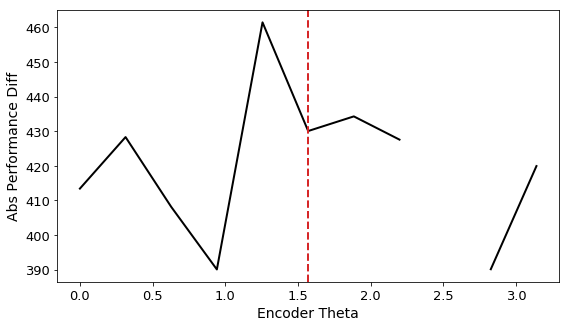

In [15]:
performance = []
for idx, sweep_res in enumerate(all_sweep_res): 
    sweep_range, metrics_x2y, metrics_y2x = sweep_res
    metrics_x2y = np.array(metrics_x2y)
    metrics_y2x = np.array(metrics_y2x)
    performance.append(np.abs(metrics_x2y - metrics_y2x).sum())

plt.figure(figsize=(9, 5))
ax = plt.subplot(1, 1, 1)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.plot(thetas, performance, lw=2, color='k')
ax.axvline(x=0.5 * np.pi, linestyle='--', lw=2, color='C3')
ax.set_xlabel("Encoder Theta", fontsize=14)
ax.set_ylabel("Abs Performance Diff", fontsize=14)
plt.savefig('figures/fixed-encoder-regret-landscape.pdf', bbox_inches='tight', format='pdf')
plt.show()

In [16]:
performance

[413.4231824874878,
 428.3049006462097,
 408.149596452713,
 390.07599234580994,
 461.43046259880066,
 430.04793751239777,
 434.2744594812393,
 427.5650850534439,
 nan,
 390.135094165802,
 419.9269849061966]